# Training 10,000 layer ReZero neural network on CIFAR-10 data

In this notebook we will see how the [ReZero](https://arxiv.org/abs/2003.04887) architecture addition enables training of very deep networks. In particular, we will load the CIFAR-10 dataset via `torchvision` and train a deep fully connected network with various architecture additions to fit the data. We will compare four different methods: A vanilla fully connected network, residual connections, LayerNorm, and ReZero. We use identical hyperparameters (except for weight initialization, see below) and ReLU activations for each case. The architectures are described in [Table 1](https://arxiv.org/abs/2003.04887).

Running time of the notebook: 6 minutes on laptop with single RTX 2060 GPU (and several hours for training 10,000 fully connected network at the end).

### Define the model

We now define the `DeepNN` model and several functions that load and prepare the data. Finally, we arrive at the function `setup_and_train`, that defines, trains and evaluates the model, and takes the following parameters as input:

`version` : Defines architecture: `'Vanilla'`, `'Residual'`, `'LayerNorm'`, or `'ReZero'`.

`epochs` : Number of epochs to train

`depth` : Depth of NN

`width` : Width of NN

`lr` : Learning rate

In [1]:
######################################################################
# Import and set manual seed

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [2]:
########################################################################
# Download and define the training set.

batchsize = 100
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


########################################################################
#Define input-output Jacobian

def get_jacobian(model, x):
    nc = x.size()[0]
    ny = x.size()[2]
    nx = x.size()[1]
    noutputs = 10
    x = x.reshape(nc*nx*ny)
    x = x.repeat(noutputs,1)
    x.requires_grad_(True)
    y = model(x.reshape(noutputs,nc,nx,ny))
    y.backward(torch.eye(noutputs).to(device))
    return x.grad.data


########################################################################
# Define fully connected network with ReLu activations and
# architectures :'ReZero', 'LayerNorm', 'Residual', 'Vanilla'

class DeepNN(nn.Module):
    def __init__(self, lr, width, depth, version):
        super(DeepNN, self).__init__()
        self.linear_input = nn.Linear(3*32*32, width)
        self.linear_layers = nn.ModuleList([nn.Linear(width, width) for i in range(depth)])
        self.linear_output = nn.Linear(width, 10)
        self.version = version
        if self.version == 'ReZero':
            self.resweight = nn.Parameter(torch.zeros(depth), requires_grad=True)
        if self.version == 'LayerNorm':
            self.ln = torch.nn.LayerNorm((width))
        #Initialize:
        torch.nn.init.kaiming_normal_(self.linear_input.weight, a=0, mode='fan_in', nonlinearity='relu')
        for i in range(depth):
            if self.version == 'ReZero':
                torch.nn.init.xavier_normal_(self.linear_layers[i].weight, gain=torch.sqrt(torch.tensor(2.)))
            elif self.version == 'Vanilla':
                torch.nn.init.xavier_normal_(self.linear_layers[i].weight, gain=torch.sqrt(torch.tensor(2.)))
            elif self.version == 'Residual':
                # See https://arxiv.org/abs/1712.08969
                torch.nn.init.xavier_normal_(self.linear_layers[i].weight, gain=torch.sqrt(torch.tensor(0.25)))
            elif self.version == 'LayerNorm':
                torch.nn.init.xavier_normal_(self.linear_layers[i].weight, gain=torch.sqrt(torch.tensor(2.)))
    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = F.relu(self.linear_input(x))
        for i, j in enumerate(self.linear_layers):
            if self.version == 'ReZero':
                x = x + self.resweight[i] *  torch.relu(self.linear_layers[i](x))
            elif self.version == 'Vanilla':
                x = F.relu(self.linear_layers[i](x))
            elif self.version == 'Residual':
                x = x + F.relu(self.linear_layers[i](x))
            elif self.version == 'LayerNorm':
                x = self.ln(F.relu(self.linear_layers[i](x)))
        x = self.linear_output(x)
        return x

def setup_and_train(epochs, lr, width, depth, version, plt_jacobian = True):
    ######################################################################
    # Model setup
    model = DeepNN(lr, width, depth, version)
    model.to(device);
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adagrad(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=1.0)
    
    ######################################################################
    # Train the model
    model.train()
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch+1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f}'.format
              (epoch+1, (time.time() - epoch_start_time),cur_loss))
        running_loss = 0.
    
    if plt_jacobian == True:
        d_collected = list()
        u_collected = list()
        for i in range(100):
            src = torch.randn(3, 32, 32).to(device)
            J = get_jacobian(model,src)
            v, d, u = torch.svd(J.to('cpu'))
            d_collected.append(d.numpy().tolist())
            u_collected.append(u.numpy().tolist())
        d_ = np.asarray(d_collected).flatten()
        print('-' * 55)
        print('Mean sq singular value of io Jacobian:', "%0.3f" % np.mean(d_**2))
        fig, ax = plt.subplots()
        opacity=.7
        plt.ylim((0,1))
        plt.xlim((-7,4))
        ax.hist(np.log(d_)/np.log(10), bins = 10, alpha = opacity, label = 'NN model: ' + version,
                density = True)
        ax.legend(loc='upper left')
        ax.set_xlabel('log (io-Jacobian singular values)')
        plt.show()


Files already downloaded and verified


### Vanilla network

A vanilla network converges very slowly. There is a large spread in the singular value spectrum of the input-output Jacobian.

| end of epoch   1 | time / epoch  7.81s | loss 54693.80
| end of epoch   2 | time / epoch  7.75s | loss  2.34
| end of epoch   3 | time / epoch  7.80s | loss  2.30
| end of epoch   4 | time / epoch  7.72s | loss  2.30
| end of epoch   5 | time / epoch  7.52s | loss  2.30
| end of epoch   6 | time / epoch  7.74s | loss  2.28
| end of epoch   7 | time / epoch  7.71s | loss  2.21
| end of epoch   8 | time / epoch  7.65s | loss  2.08
| end of epoch   9 | time / epoch  7.84s | loss  2.05
| end of epoch  10 | time / epoch  7.67s | loss  2.02
-------------------------------------------------------
Mean sq singular value of io Jacobian: 0.829


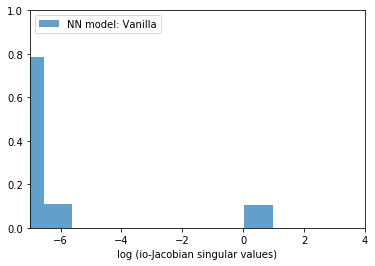

In [3]:
######################################################################
# The model is set up with the hyperparameter below.

version = 'Vanilla'  # Architecture
epochs = 10           # Number of epochs
depth = 64            # Number of layers
width = 256           # Width
lr = 0.01             # Learning rate for Adagrad optimizer

setup_and_train(epochs, lr, width, depth, version, plt_jacobian = True)

### Residual network

A network with a residual connection converges a bit better. There still is a large spread in the singular value spectrum of the input-output Jacobian.

| end of epoch   1 | time / epoch  8.61s | loss 131269.63
| end of epoch   2 | time / epoch  9.10s | loss 26.92
| end of epoch   3 | time / epoch  8.70s | loss 11.76
| end of epoch   4 | time / epoch  8.47s | loss  4.55
| end of epoch   5 | time / epoch  8.81s | loss  2.32
| end of epoch   6 | time / epoch  9.79s | loss  2.10
| end of epoch   7 | time / epoch  8.93s | loss  2.00
| end of epoch   8 | time / epoch  8.42s | loss  1.95
| end of epoch   9 | time / epoch  8.65s | loss  1.91
| end of epoch  10 | time / epoch  8.41s | loss  1.87
-------------------------------------------------------
Mean sq singular value of io Jacobian: 225.593


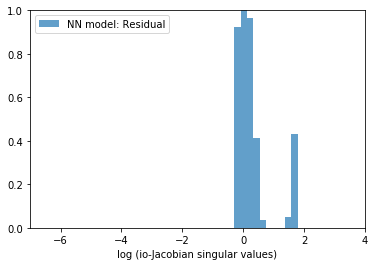

In [4]:
######################################################################
# The model is set up with the hyperparameter below.

version = 'Residual'  # Architecture
epochs = 10           # Number of epochs
depth = 64            # Number of layers
width = 256           # Width
lr = 0.01             # Learning rate for Adagrad optimizer

setup_and_train(epochs, lr, width, depth, version, plt_jacobian = True)

### LayerNorm network

A LayerNorm network converges very slowly.

| end of epoch   1 | time / epoch  9.97s | loss  2.23
| end of epoch   2 | time / epoch 10.18s | loss  2.14
| end of epoch   3 | time / epoch  9.88s | loss  2.14
| end of epoch   4 | time / epoch 10.14s | loss  2.11
| end of epoch   5 | time / epoch 10.80s | loss  2.09
| end of epoch   6 | time / epoch 10.61s | loss  2.06
| end of epoch   7 | time / epoch 10.23s | loss  2.04
| end of epoch   8 | time / epoch 10.40s | loss  2.02
| end of epoch   9 | time / epoch  9.90s | loss  2.01
| end of epoch  10 | time / epoch 10.12s | loss  2.02
-------------------------------------------------------
Mean sq singular value of io Jacobian: 12.412


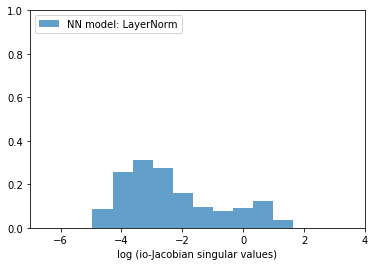

In [5]:
######################################################################
# The model is set up with the hyperparameter below.

version = 'LayerNorm'  # Architecture
epochs = 10           # Number of epochs
depth = 64            # Number of layers
width = 256           # Width
lr = 0.01             # Learning rate for Adagrad optimizer

setup_and_train(epochs, lr, width, depth, version, plt_jacobian = True)

### ReZero network

A deep neural network with ReZero connection quickly converges.

| end of epoch   1 | time / epoch 11.33s | loss  1.68
| end of epoch   2 | time / epoch 11.57s | loss  1.37
| end of epoch   3 | time / epoch 10.92s | loss  1.24
| end of epoch   4 | time / epoch 11.80s | loss  1.14
| end of epoch   5 | time / epoch 11.87s | loss  1.04
| end of epoch   6 | time / epoch 11.54s | loss  0.94
| end of epoch   7 | time / epoch 10.90s | loss  0.84
| end of epoch   8 | time / epoch 10.96s | loss  0.73
| end of epoch   9 | time / epoch 10.92s | loss  0.63
| end of epoch  10 | time / epoch 11.24s | loss  0.52
-------------------------------------------------------
Mean sq singular value of io Jacobian: 18.082


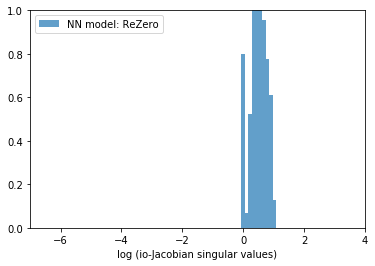

In [6]:
######################################################################
# The model is set up with the hyperparameter below.

version = 'ReZero'  # Architecture
epochs = 10           # Number of epochs
depth = 64            # Number of layers
width = 256           # Width
lr = 0.01             # Learning rate for Adagrad optimizer

setup_and_train(epochs, lr, width, depth, version, plt_jacobian = True)

### 10000 layer ReZero network

We can train a 10000 layer neural network with ReZero. This takes several hours, so consider your actions.

In [ ]:
######################################################################
# The model is set up with the hyperparameter below.

version = 'ReZero'  # Architecture
epochs = 25           # Number of epochs
depth = 10000            # Number of layers
width = 150           # Width
lr = 0.003             # Learning rate for Adagrad optimizer

setup_and_train(epochs, lr, width, depth, version, plt_jacobian = False)